In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import warnings

# Cleaning

## Data import, handling, and cleaning 

In [4]:
import pandas as pd
import json
from datetime import datetime, timedelta
from sklearn.impute import KNNImputer

# Load data
pop_data = pd.read_csv('../data/pop_data_cantons/weekly_imputed_pop_data_final_region.csv')
flu_data = pd.read_csv('../data/INFLUENZA_sentinella/data.csv')
weather_data = pd.read_csv('../data/weather/reg_weather.csv')
google_flu_data = pd.read_csv('../data/google_search_trend/reg_google_grippe.csv')
google_symptoms_data = pd.read_csv('../data/google_search_trend/reg_google_fieber_husten.csv')

# Processing flu_data
flu_CH = flu_data.query('georegion_type == "country" and agegroup == "all" and sex == "all"').copy()
flu_reg = flu_data.query('georegion_type == "sentinella_region" and agegroup == "all" and sex == "all"').copy()
flu_reg = flu_reg[~(flu_reg['georegion'] == 'unknown')]

selected_cols = ['temporal', 'georegion', 'popExtrapolation', 'incValue']
flu_reg = flu_reg[selected_cols]
flu_reg.rename(columns={'popExtrapolation': 'flu_cases'}, inplace=True)

# Align time-indexes of google data and flu data
with open('date_dict.json', 'r') as f:
    date_dict = json.load(f)

def align_dates(df):
    df['Woche'] = df['Woche'].apply(lambda x: date_dict.get(x, x))
    return df

google_flu_data = align_dates(google_flu_data)
google_symptoms_data = align_dates(google_symptoms_data)

# Convert dates to 'YYYY-Www' ISO week format
def convert_to_iso_week(date_str):
    year, week, _ = datetime.strptime(date_str, '%Y-%m-%d').isocalendar()
    return f'{year}-W{week:02d}'

weather_data['date'] = weather_data['date'].apply(convert_to_iso_week)

# Reshape and process Google data
def process_google_data(df):
    df = df.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')
    df['region'] = df['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
    df['query'] = df['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
    df.drop(columns='region_query', inplace=True)
    return df.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

google_flu_data = process_google_data(google_flu_data)
google_symptoms_data = process_google_data(google_symptoms_data)

# Merging datasets
merged_data = pd.merge(flu_reg, weather_data, how='left', left_on=['temporal', 'georegion'], right_on=['date', 'region'])
merged_google = pd.merge(google_flu_data, google_symptoms_data, how='inner', on=['region', 'Woche'])
merged_data = pd.merge(merged_data, merged_google, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Woche'])
merged_data = pd.merge(merged_data, pop_data, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Jahr-Woche'])
merged_data.drop(columns=['region_x', 'region_y', 'date', 'Woche_x', 'Woche_y', 'Jahr-Woche', 'Bevölkerung 31. Dezember'], inplace=True)

# Additional Functions
def iso_year_start(iso_year):
    fourth_jan = datetime(iso_year, 1, 4)
    delta = timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    year_start = iso_year_start(iso_year)
    return year_start + timedelta(days=iso_day-1, weeks=iso_week-1)

# Interpolating missing values in incValue column
lagged_df = merged_data.copy()
lagged_df['incValue'].interpolate(inplace=True)

lagged_df = merged_data.copy()
lagged_df['incValue'].interpolate(inplace=True)

# Extract week number and year from temporal and convert to dates
pattern = r'W(\d{1,2})'

# Ensure the extraction is properly applied to the Series
lagged_df['week_number'] = lagged_df['temporal'].str.extract(pattern)[0].astype(int)

lagged_df['year'] = lagged_df['temporal'].apply(lambda x: x.split('-')[0])
lagged_df['year'] = pd.to_numeric(lagged_df['year'])

# Convert from iso-calendar week to dates
lagged_df['date'] = list(map(lambda year, week: iso_to_gregorian(year, week, 4), lagged_df['year'], lagged_df['week_number']))

lagged_df.set_index('date', inplace=True)


df_with_dummies = pd.get_dummies(lagged_df, columns=['georegion'], drop_first=False)

df_with_dummies = df_with_dummies[df_with_dummies.index < "2020-01-01"]
df_with_dummies["temp_diff"] = df_with_dummies["weighted_max_daily_temp"] - df_with_dummies["weighted_min_daily_temp"]
df_with_dummies["hum_diff"] = df_with_dummies['weighted_max_daily_hum'] - df_with_dummies['weighted_min_daily_hum']

df_with_dummies = df_with_dummies.drop(['flu_cases',  'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)', "weighted_max_daily_temp",
                                        "weighted_min_daily_temp", 'weighted_max_daily_hum', 'weighted_min_daily_hum', 'Flu_resid', 'Flu_seasonal', 'Flu_trend',
                                        'Grippe_resid', 'Grippe_seasonal', 'Grippe_trend', 'Influenza_resid', 'Influenza_seasonal', 'Influenza_trend',
                                        'influenza_resid', 'influenza_seasonal', 'influenza_trend', 'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend',
                                        'fièvre_resid','fièvre_seasonal', 'fièvre_trend', 'husten_resid', 'husten_seasonal', 'husten_trend', 'toux_resid',
                                        'toux_seasonal', 'toux_trend', 'region', 'week_number', 'year'], axis = 1)

# Assuming df_with_dummies is your original DataFrame
df_with_dummies_train = df_with_dummies[df_with_dummies.index < "2019-01-01"]
df_with_dummies_test = df_with_dummies[df_with_dummies.index >= "2019-01-01"]

#KNN Imputer using the 10 nearest neighboring data to impute the missing values
train_impute = df_with_dummies_train.copy()
imputer = KNNImputer(n_neighbors=10)
train_imputed = imputer.fit_transform(train_impute)
train_imputed_df = pd.DataFrame(train_imputed, columns=train_impute.columns, index=train_impute.index)
nulls_train = train_imputed_df.isnull().sum().sum()
print("there are", nulls_train, "zeros in the train data")

test_impute = df_with_dummies_test.copy()
test_imputed = imputer.fit_transform(test_impute)
test_imputed_df = pd.DataFrame(test_imputed,columns=test_impute.columns, index=test_impute.index)
nulls_test = test_imputed_df.isnull().sum().sum()
print("there are", nulls_test, "zeros in the test data")
df_with_dummies = pd.concat([train_imputed_df, test_imputed_df], axis = 0)

df_with_dummies['value_log'] = df_with_dummies['incValue'] + 1
y_log = np.log(df_with_dummies['value_log'])
if (df_with_dummies['value_log'] == 0).any():
    print("There are zeros in the column")
else:
    print("No zeros in the column")
df_with_dummies["log"] = y_log
df_with_dummies = df_with_dummies.drop('value_log', axis = 1)

there are 0 zeros in the train data
there are 0 zeros in the test data
No zeros in the column


## Dictionary with Regions

In [5]:
var = ["incValue", "log", 'weighted_avg_daily_temp', 'weighted_avg_daily_hum','temp_diff', 'hum_diff',
       'Flu', 'Grippe', 'Influenza', 'influenza', 'Fieber', 'fièvre', 'husten','toux',
       'Geburten', 'Todesfälle', 'Überschuss', 'Wanderungssaldo international 1', 
       'Wanderungssaldo interkantonal', 'total', '% over Year', 'Alter 0–19', 'Alter 20–64',
       'Alter 65 und mehr', 'Mann', 'Frau', 'Schweizer', 'Ausländer ', 'Ledig',
       'Verheiratet', 'Verwitwet', 'Geschieden', 'Unverheiratet',
       'In eingetragener Partnerschaft', 'Aufgelöste Partnerschaft',
       'Städtischer Kernraum', 'Einflussgebiet Stadt',
       'Ausserhalb des Einflusses städtischer Kerne', 'BIP in Millionen CHF',
       'BIP Growth Laufende Preise', 'BIP Growth Preise Vorjahr',
       'BIP pro Kopf', 'Bevölkerung', '% over week', 'Pop Density']

exo = ['weighted_avg_daily_temp', 'weighted_avg_daily_hum','temp_diff', 'hum_diff',
       'Flu', 'Grippe', 'Influenza', 'influenza', 'Fieber', 'fièvre', 'husten','toux',
       'Geburten', 'Todesfälle', 'Überschuss', 'Wanderungssaldo international 1', 
       'Wanderungssaldo interkantonal', 'total', '% over Year', 'Alter 0–19', 'Alter 20–64',
       'Alter 65 und mehr', 'Mann', 'Frau', 'Schweizer', 'Ausländer ', 'Ledig',
       'Verheiratet', 'Verwitwet', 'Geschieden', 'Unverheiratet',
       'In eingetragener Partnerschaft', 'Aufgelöste Partnerschaft',
       'Städtischer Kernraum', 'Einflussgebiet Stadt',
       'Ausserhalb des Einflusses städtischer Kerne', 'BIP in Millionen CHF',
       'BIP Growth Laufende Preise', 'BIP Growth Preise Vorjahr',
       'BIP pro Kopf', 'Bevölkerung', '% over week', 'Pop Density']

# Dictionary is created to store the exogenous variables for each 'georegion_region_X'
georegion_dict = {}

# Iterate over 'georegion_region_X' keys
for i in range(1, 7):
    georegion_key = f'georegion_region_{i}'
    
    condition = df_with_dummies[georegion_key] == True

    # Filter the DataFrame based on the condition
    selected_data = df_with_dummies[condition][var]

    # Add the selected exogenous variables to the dictionary
    georegion_dict[georegion_key] = selected_data

# Create a DataFrame from the dictionary
georegion_df = pd.concat(georegion_dict, axis=1)

missing_values = georegion_df.isnull().sum().sum()
print("Missing values in the DataFrame:", missing_values)


Missing values in the DataFrame: 0


## Train Test Split

In [7]:
# Data before 2019 are the train data, and after 2019 are the test data

georegion_df_train = georegion_df[georegion_df.index < "2019-01-01"]
georegion_df_test = georegion_df[georegion_df.index >= "2019-01-01"]

X = georegion_df.drop(["incValue", 'log'], axis = 1, level = 1)
y = georegion_df.drop(exo, level=1, axis=1)


X_train = georegion_df_train.drop(["incValue", 'log'], axis = 1, level = 1)
y_train = georegion_df_train.drop(exo, level=1, axis=1)
y_test = georegion_df_test.drop(exo, level=1, axis=1)

## Overview of the Time Serie across 6 Regions

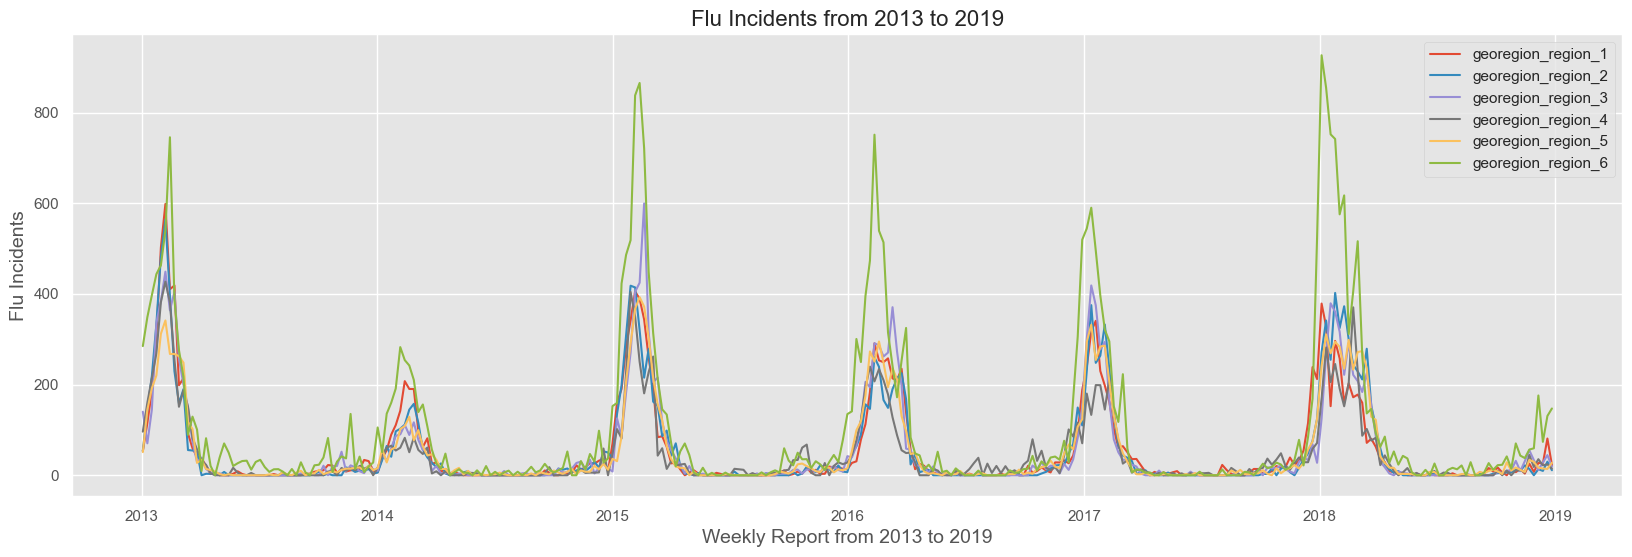

In [79]:
import seaborn as sns

# Create a figure and axis
plt.figure(figsize=(20, 6))

# Plot the data for each georegion
for i in range(1, 7):
    georegion_key = f'georegion_region_{i}'
    sns.lineplot(data = y_train[georegion_key]["incValue"], linewidth=1.5, label=georegion_key)

# Set the title and labels with white font color
plt.title("Flu Incidents from 2013 to 2019", fontsize=16)
plt.xlabel("Weekly Report from 2013 to 2019", fontsize=14)
plt.ylabel("Flu Incidents", fontsize=14)

plt.show()


# Region 5

## Decomposition with KPSS and ADF tests

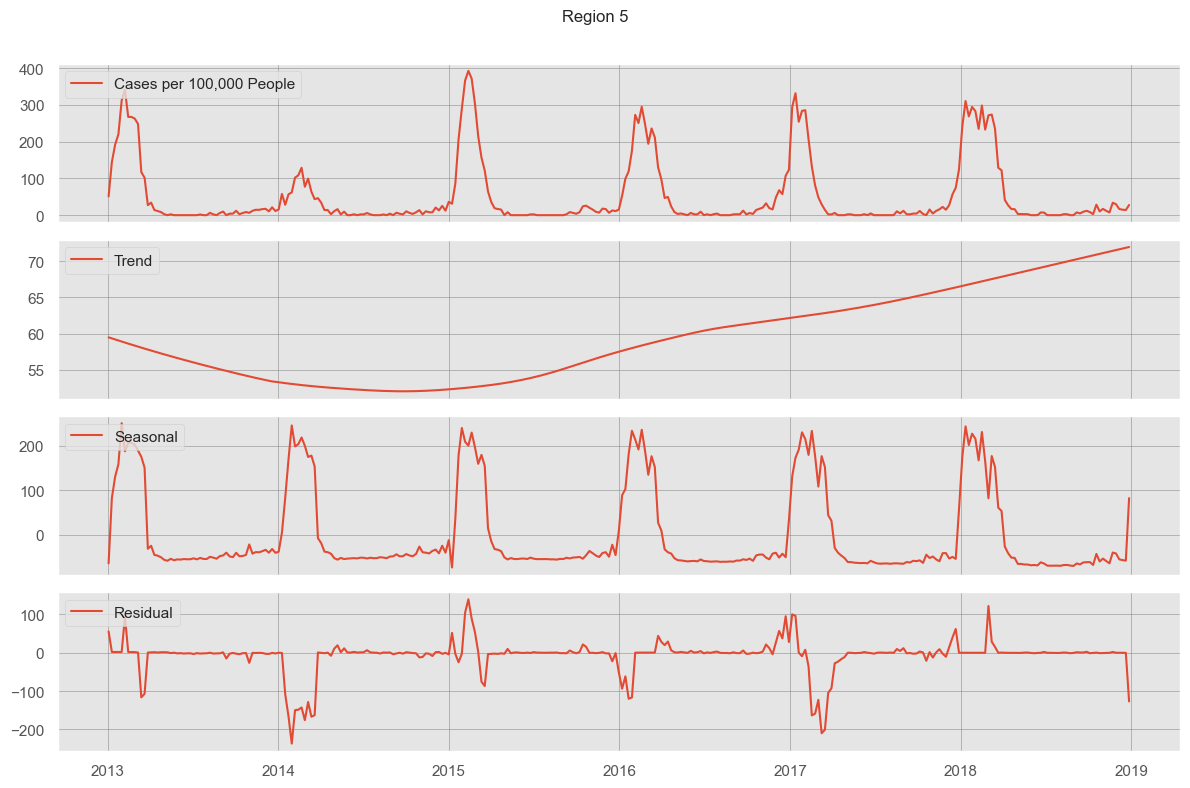

Region 5 KPSS and ADF tests
KPSS Test Statistic: 0.03513658125849087
P-value: 0.1
This time series is stationary (do not reject the null hypothesis), no need for differencing
ADF Test Statistic: -5.419167020354303
P-value: 3.086967415235905e-06
This time series is stationary (reject the null hypothesis)


Region 5 Residual KPSS and ADF tests 
KPSS Test Statistic: 0.10646459413963483
P-value: 0.1
The residual of this time series is stationary (do not reject the null hypothesis), no need for differencing
ADF Test Statistic: -5.678325246395143
P-value: 8.601425846870837e-07
The residual of this time series is stationary (reject the null hypothesis)


In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Set Seaborn style and parameters
plt.style.use('ggplot')
# Create a figure and axis

decomp = STL(y_train["georegion_region_5"]["incValue"], period= 52, robust = True).fit()
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Create subplots with proper spacing
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
fig.suptitle("Region 5")

# Original Time Series
axs[0].plot(y_train["georegion_region_5"]["incValue"], label='Cases per 100,000 People')
axs[0].legend(loc='upper left')

# Trend Component
axs[1].plot(trend, label='Trend')
axs[1].legend(loc='upper left')

# Seasonal Component
axs[2].plot(seasonal, label='Seasonal')
axs[2].legend(loc='upper left')

# Residual Component
axs[3].plot(residual, label='Residual')
axs[3].legend(loc='upper left')

for ax in axs:
    ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.7)


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Perform the KPSS test on log-tranformation
print(f"Region 5 KPSS and ADF tests")

# kpss Test
result = kpss(y_train["georegion_region_5"]["incValue"])
print(f'KPSS Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

if result[1] < 0.05:
    print('This time series is non-stationary (reject the null hypothesis), need for differencing')
else:
    print('This time series is stationary (do not reject the null hypothesis), no need for differencing')

# ADF test
result = adfuller(y_train["georegion_region_5"]["incValue"])
print(f'ADF Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

if result[1] < 0.05:
    print('This time series is stationary (reject the null hypothesis)')
else:
    print('This time series is non-stationary (do not reject the null hypothesis)')
    
print("\n")

# KPSS test on the residual of train data
print(f"Region 5 Residual KPSS and ADF tests ")
residual = residual.dropna()
result = kpss(residual)
print(f'KPSS Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

if result[1] < 0.05:
    print('The residual of this time series is non-stationary (reject the null hypothesis), need for differencing')
else:
    print('The residual of this time series is stationary (do not reject the null hypothesis), no need for differencing')

# ADF test on the residual of train data
result = adfuller(residual)
print(f'ADF Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

# Compare the test statistic with critical values to make a decision
if result[1] < 0.05:
    print('The residual of this time series is stationary (reject the null hypothesis)')
else:
    print('The residual of this time series is non-stationary (do not reject the null hypothesis)')

# Persisting pattern in the residual, which coudd imply a need for differencing, regardless the result of KPSS and ADF tests.

## First and Second Order of Ordinary Differncing 

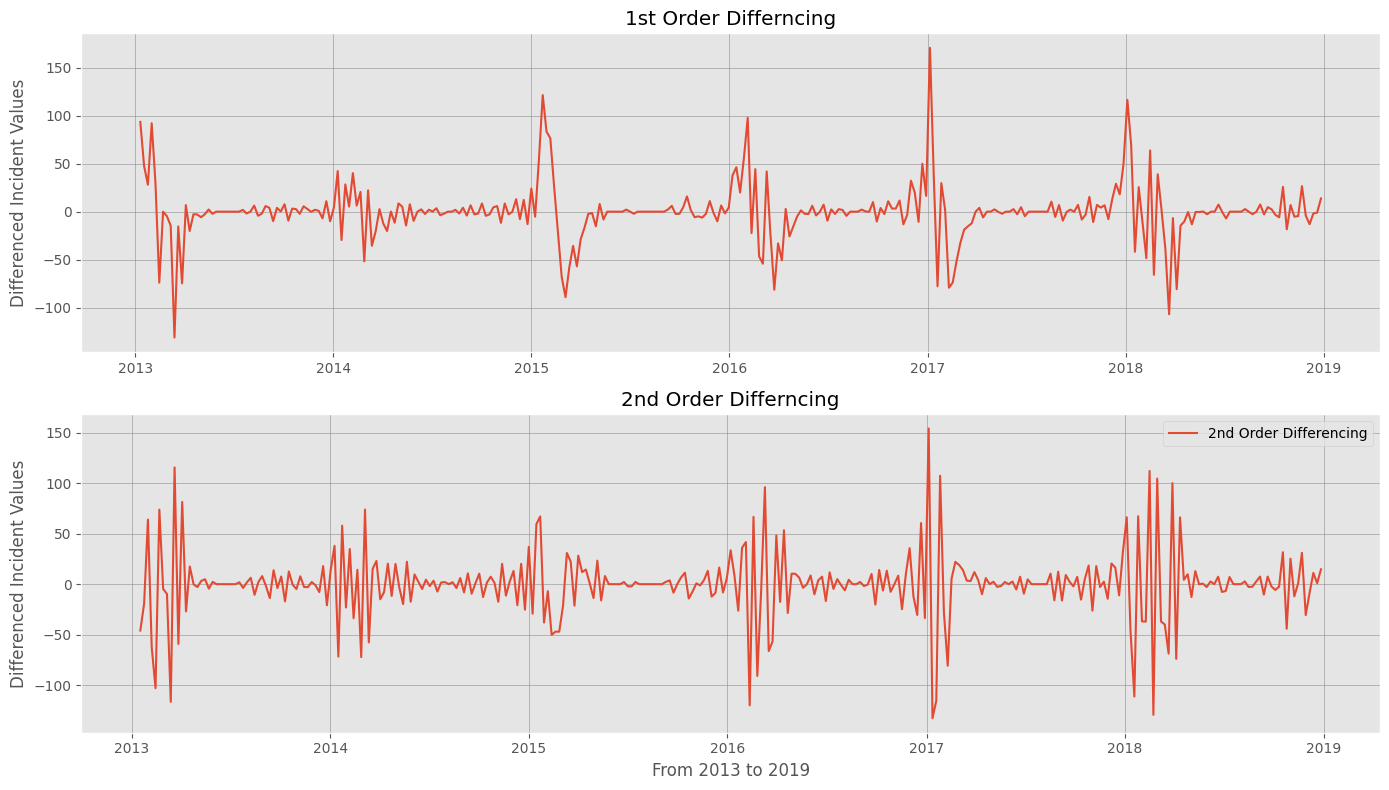

In [9]:
diff1 = pd.DataFrame(y_train["georegion_region_5"]["incValue"].diff())
diff1 = diff1.dropna()

diff2 = pd.DataFrame(diff1.diff())
diff2 = diff2.dropna()

plt.style.use('ggplot')
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot for 1st Order Differencing
axs[0].plot(diff1, label='1st Order Differencing ')
axs[0].set_ylabel('Differenced Incident Values')
axs[0].set_title('1st Order Differncing')
axs[0].grid()  # Add grid to the first plot

# Plot for 2nd Order Differencing
axs[1].plot(diff2, label='2nd Order Differencing')
axs[1].set_xlabel('From 2013 to 2019')
axs[1].set_ylabel('Differenced Incident Values')
axs[1].set_title('2nd Order Differncing')
axs[1].grid()

for ax in axs:
    ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.7)


plt.tight_layout()
plt.legend()
plt.show()

# Although both KPSS and ADF tests suggest that the data is stationary, however both 1st and 2nd order of ordinary differenicng are perofrmed.
# Eyeballing both graphs gives the impression that seasonal differencing is needed
# Log-transformation will be applied to the data for stabalising the variance for a better performance of ARIMA model.

## Decomposition with KPSS and ADF tests (log-tranformation)

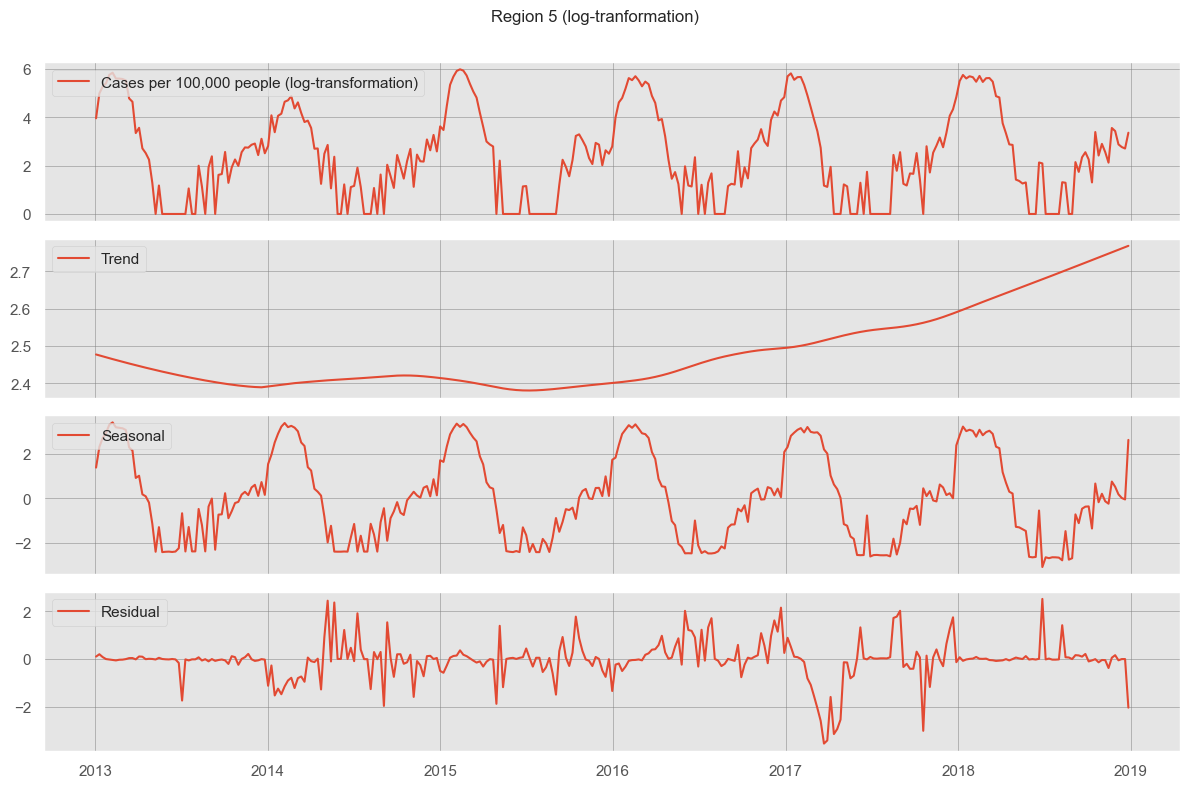

Region 5 KPSS and ADF tests (log-tranformation)
KPSS Test Statistic: 0.027151392823875437
P-value: 0.1
This time series is stationary (do not reject the null hypothesis), no need for differencing
ADF Test Statistic: -5.966234636708341
P-value: 1.9847382703444355e-07
This time series is stationary (reject the null hypothesis)


Region 5 Residual KPSS and ADF tests (log-tranformation)
KPSS Test Statistic: 0.04698869044209658
P-value: 0.1
The residual of this time series is stationary (do not reject the null hypothesis), no need for differencing
ADF Test Statistic: -5.411574494184625
P-value: 3.202668663653098e-06
The residual of this time series is stationary (reject the null hypothesis)


In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Set Seaborn style and parameters
plt.style.use('ggplot')

# Create a figure and axis

decomp = STL(y_train["georegion_region_5"]["log"], period= 52, robust = True).fit()
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Create subplots with proper spacing
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
fig.suptitle("Region 5 (log-tranformation)")

# Original Time Series
axs[0].plot(y_train["georegion_region_5"]["log"], label='Cases per 100,000 people (log-transformation)')
axs[0].legend(loc='upper left')

# Trend Component
axs[1].plot(trend, label='Trend')
axs[1].legend(loc='upper left')

# Seasonal Component
axs[2].plot(seasonal, label='Seasonal')
axs[2].legend(loc='upper left')

# Residual Component
axs[3].plot(residual, label='Residual')
axs[3].legend(loc='upper left')

for ax in axs:
    ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Perform the KPSS test on log-tranformation
print(f"Region 5 KPSS and ADF tests (log-tranformation)")

# kpss Test
result = kpss(y_train["georegion_region_5"]["log"])
print(f'KPSS Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

if result[1] < 0.05:
    print('This time series is non-stationary (reject the null hypothesis), need for differencing')
else:
    print('This time series is stationary (do not reject the null hypothesis), no need for differencing')

# Perform the ADF test
result = adfuller(y_train["georegion_region_5"]["log"])
print(f'ADF Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

if result[1] < 0.05:
    print('This time series is stationary (reject the null hypothesis)')
else:
    print('This time series is non-stationary (do not reject the null hypothesis)')
    
print("\n")

# KPSS test on the residual of train data
print(f"Region 5 Residual KPSS and ADF tests (log-tranformation)")
residual = residual.dropna()
result = kpss(residual)
print(f'KPSS Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

if result[1] < 0.05:
    print('The residual of this time series is non-stationary (reject the null hypothesis), need for differencing')
else:
    print('The residual of this time series is stationary (do not reject the null hypothesis), no need for differencing')

# ADF test on the residual of train data
result = adfuller(residual)
print(f'ADF Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

# Compare the test statistic with critical values to make a decision
if result[1] < 0.05:
    print('The residual of this time series is stationary (reject the null hypothesis)')
else:
    print('The residual of this time series is non-stationary (do not reject the null hypothesis)')

# The pattern in the residual seems to disappear after log-transformation

## ACF and PACF on Log-transformation

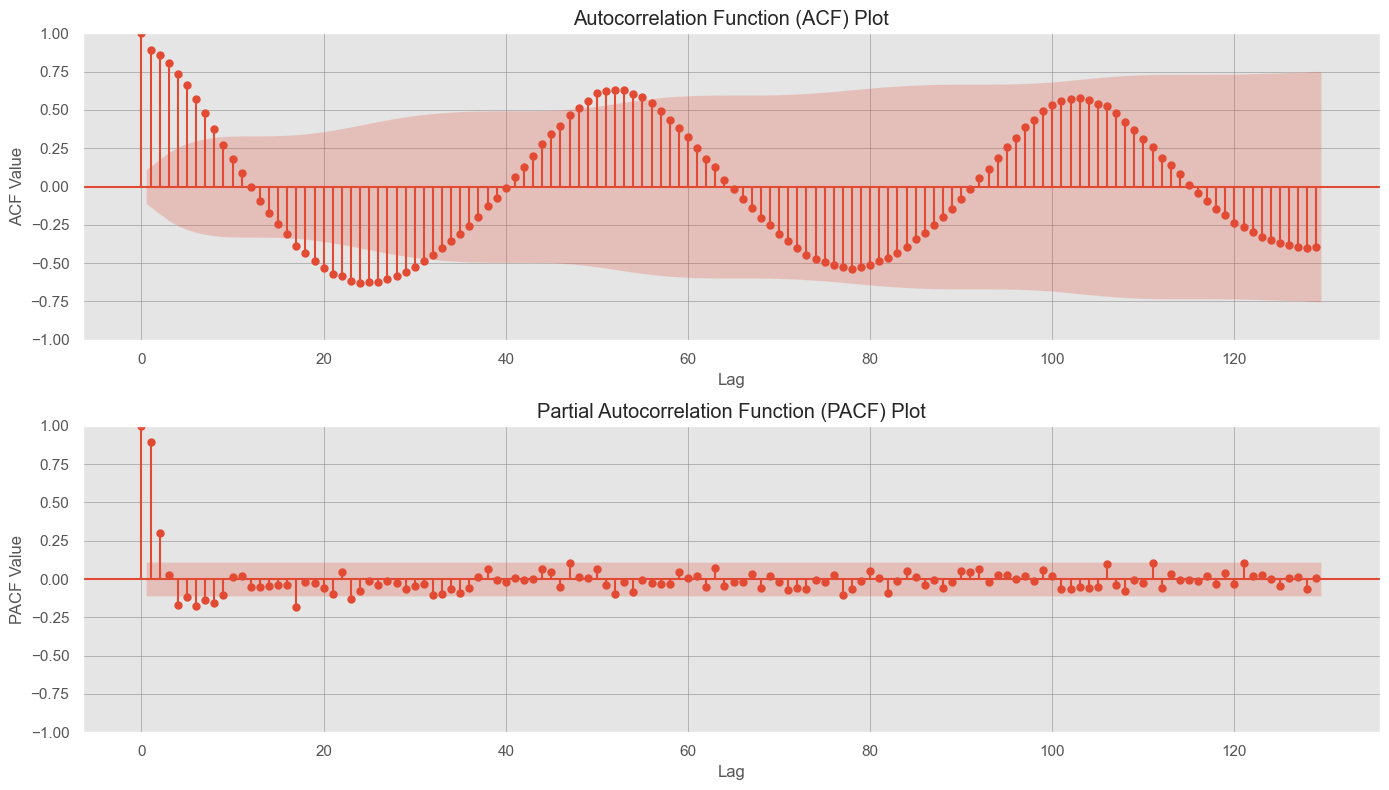

In [100]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(y_train["georegion_region_5"]["log"], lags=129, ax=axs[0])  
axs[0].set_title('Autocorrelation Function (ACF) Plot')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(y_train["georegion_region_5"]["log"], lags=129, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()
for ax in axs:
    ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.7)
    
plt.tight_layout()
plt.show() 
# ACF decays slowly with a sine-wave like patterm.
# Significant spikes on the tips of the sine-wave ACF graph, which indicates a need for seasonal differencing
# PACF show no sigficiant spike after 9th lag
# From ACF and PACF we could induce that it could be a AR(6) model, meaning ARIMA (9,0,0)

### ARIMA by Eyeballing

84.57255721645625


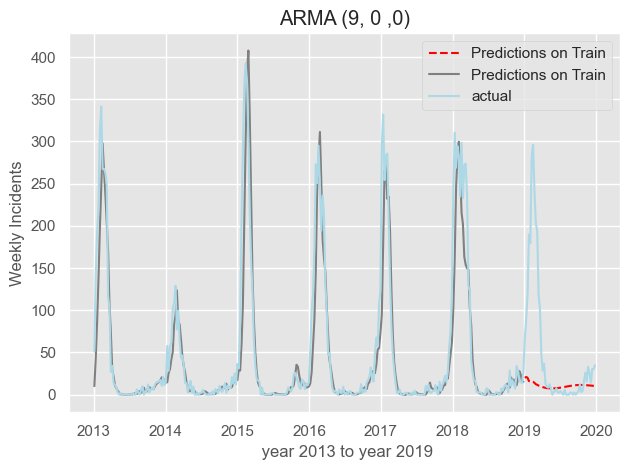

In [111]:
model_arima = ARIMA(y_train["georegion_region_5"]["log"],
                            order=(9, 0, 0),).fit()

pred_arima = model_arima.predict(start=len(y_train), end=len(y_train) + len(y_test)-1, dynamic=False)
pred_arima = np.exp(pred_arima) - 1
pred_data_arima = pd.DataFrame({'pred': pred_arima})
pred_data_arima.index = y_test.index

rmse_value = mean_squared_error(y_test["georegion_region_5"]["incValue"], pred_data_arima, squared=False)

pred_arima = model_arima.predict(start=0, end=len(y_train)-1, dynamic=False)
pred_arima = np.exp(pred_arima) - 1
pred_data_arima_train = pd.DataFrame({'pred': pred_arima})
pred_data_arima_train.index = y_train.index

print(rmse_value)

plt.title(f"ARMA (9, 0 ,0)")
plt.ylabel("Weekly Incidents")
plt.xlabel(" year 2013 to year 2020")
plt.plot(pred_data_arima, color="red", label="Predictions on Test", linestyle='--')
plt.plot(pred_data_arima_train, color="grey", label="Predictions on Train")
plt.plot(y["georegion_region_5"]["incValue"], color="lightblue", label="actual")
plt.legend()
plt.tight_layout()
plt.show()

# Prediction on train data is quite accurate
# However the spike in 2019 is not captured in the prediction of test data
# This result is expected, because the nature of ARIMA model indicates that prediction converges to a constant in the long-term

## Gridsearch ARIMA Model

In [103]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np
import warnings
warnings.filterwarnings('ignore')

aic_values = {}
RMSE = {}

d = 0


dates = ["2014-12-31", "2015-12-31", "2016-12-31", "2017-12-31", "2018-12-31", "2019-12-31"]

for p in range(2, 5):
    for q in range(4, 12):

        temp_aic_values = []
        temp_rmse_values = []

        for t in range(0, 5):

            current_train = georegion_df[georegion_df["georegion_region_5"].index <= dates[t]]
            current_test = georegion_df[(georegion_df["georegion_region_5"].index > dates[t]) & (georegion_df["georegion_region_5"].index <= dates[t + 1])]

            model_arima = ARIMA(y_train["georegion_region_5"]["log"],
                            order=(p, d, q),).fit()
            temp_aic_values.append(model_arima.aic)

            pred = model_arima.predict(start=len(current_train), end=len(current_train) + len(current_test) - 1, dynamic=False)
            pred = np.exp(pred) - 1
            pred_data = pd.DataFrame({'pred': pred})
            pred_data.index = current_test.index
            rmse_value = mean_squared_error(current_test["georegion_region_5"]["incValue"], pred_data, squared=False)
            temp_rmse_values.append(rmse_value)

        average_aic = np.mean(temp_aic_values)
        average_rmse = np.mean(temp_rmse_values)


        aic_values[(p, d, q)] = average_aic
        RMSE[(p, d, q)] = average_aic

        print(f"ARIMA({p}, {d}, {q}) with regional AIC: {aic_values[(p, d, q)]}, regional RMSE is {RMSE[(p, d, q)]}")

# Finding the best parameters
best_pdq_aic = min(aic_values, key=aic_values.get)
print("Lowest AIC ARIMA is:", best_pdq_aic, aic_values[best_pdq_aic])

best_pdq_rmse = min(RMSE, key=RMSE.get)
print("Lowest RMSE ARIMA is:", best_pdq_rmse, RMSE[best_pdq_rmse])

# A 5-fold expanding cross validation is performed.

ARIMA(2, 0, 4) with regional AIC: 700.2963583621824, regional RMSE is 700.2963583621824
ARIMA(2, 0, 5) with regional AIC: 702.5017368484074, regional RMSE is 702.5017368484074
ARIMA(2, 0, 6) with regional AIC: 700.6022514387714, regional RMSE is 700.6022514387714
ARIMA(2, 0, 7) with regional AIC: 702.4822078330437, regional RMSE is 702.4822078330437
ARIMA(2, 0, 8) with regional AIC: 732.4816048979337, regional RMSE is 732.4816048979337
ARIMA(2, 0, 9) with regional AIC: 733.781882055003, regional RMSE is 733.781882055003
ARIMA(2, 0, 10) with regional AIC: 718.350720121552, regional RMSE is 718.350720121552
ARIMA(2, 0, 11) with regional AIC: 733.7956312246213, regional RMSE is 733.7956312246213
ARIMA(3, 0, 4) with regional AIC: 701.8453227463388, regional RMSE is 701.8453227463388
ARIMA(3, 0, 5) with regional AIC: 704.2925821350974, regional RMSE is 704.2925821350974
ARIMA(3, 0, 6) with regional AIC: 702.5272511676764, regional RMSE is 702.5272511676764
ARIMA(3, 0, 7) with regional AIC: 

84.25593871664493


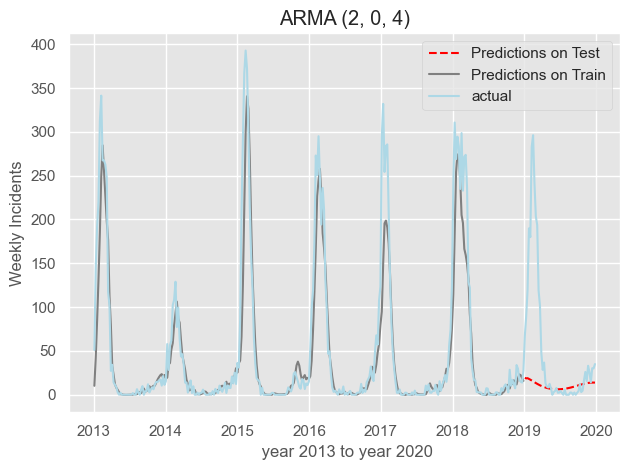

In [116]:
model_arima = ARIMA(y_train["georegion_region_5"]["log"],
                            order=(2, 0, 4),).fit()

pred_arima = model_arima.predict(start=len(y_train), end=len(y_train) + len(y_test)-1, dynamic=False)
pred_arima = np.exp(pred_arima) - 1
pred_data_arima = pd.DataFrame({'pred': pred_arima})
pred_data_arima.index = y_test.index

rmse_value = mean_squared_error(y_test["georegion_region_5"]["incValue"], pred_data_arima, squared=False)
print(rmse_value)

pred_arima = model_arima.predict(start=0, end=len(y_train)-1, dynamic=False)
pred_arima = np.exp(pred_arima) - 1
pred_data_arima_train = pd.DataFrame({'pred': pred_arima})
pred_data_arima_train.index = y_train.index

plt.title(f"ARMA (2, 0, 4)")
plt.ylabel("Weekly Incidents")
plt.xlabel(" year 2013 to year 2020")
plt.plot(pred_data_arima, color="red", label="Predictions on Test", linestyle='--')
plt.plot(pred_data_arima_train, color="grey", label="Predictions on Train")
plt.plot(y["georegion_region_5"]["incValue"], color="lightblue", label="actual")
plt.legend()
plt.tight_layout()
plt.show()

# Very little improve in the prediction as RMSE only decrease by the first decimal place.

In [114]:
# Save the DataFrame as a CSV file
prediction_ARMA_5 = pd.concat([pred_data_arima, pred_data_arima_train], axis = 0)
prediction_ARMA_5.index = y.index
file_path = 'prediction_ARMA_5.csv'
prediction_ARMA_5.to_csv(file_path, index=True)

## Seasonal Differencing

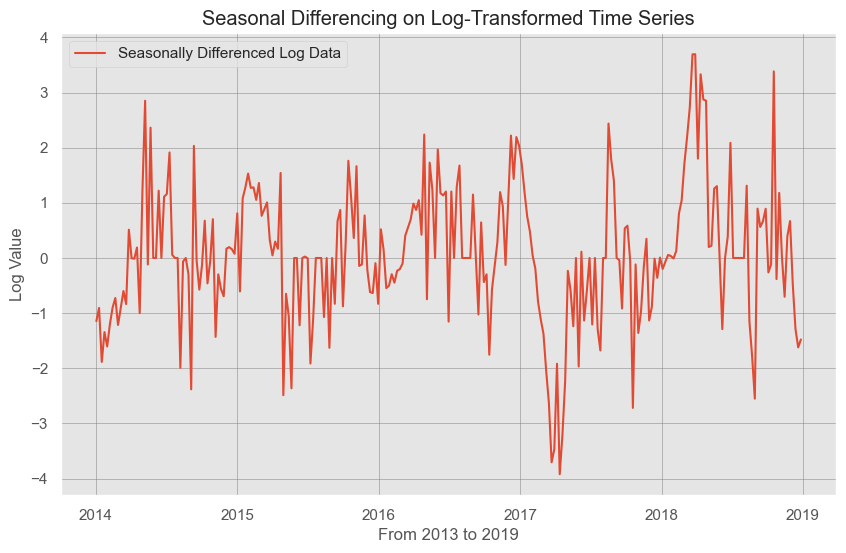

In [97]:
# Seasonal differencing on the log-transformed data with a lag of 52 since its weekly data
season = 52
seasonal_differenced_data = y_train["georegion_region_5"]["log"].diff(season)
seasonal_differenced_data = seasonal_differenced_data.dropna()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(seasonal_differenced_data, label='Seasonally Differenced Log Data')
ax.set_title('Seasonal Differencing on Log-Transformed Time Series')
ax.set_xlabel('From 2013 to 2019')
ax.set_ylabel('Log Value')
ax.legend()
ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.7)
plt.show()

# After seasonl differencing on log-transformation, stationarity is achieved here and the pattern disappears.

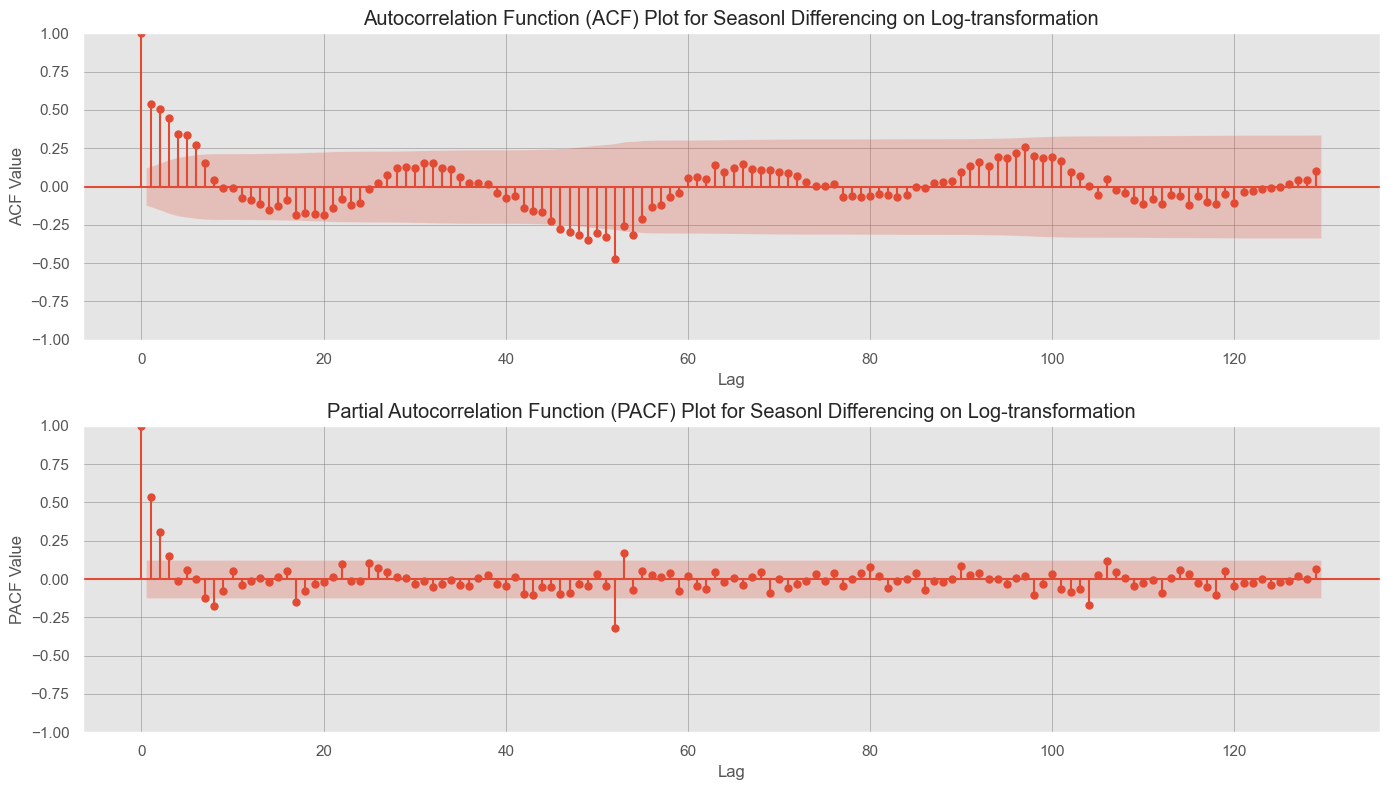

In [102]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# ACF
plot_acf(seasonal_differenced_data, lags=129, ax=axs[0]) 
axs[0].set_title('Autocorrelation Function (ACF) Plot for Seasonl Differencing on Log-transformation')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# PACF
plot_pacf(seasonal_differenced_data, lags=129, ax=axs[1])  
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot for Seasonl Differencing on Log-transformation')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()
for ax in axs:
    ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Decaying ACF with no significant spikes in the first season after 6th spike, following with a single significant spike around lag 52
# PACF decays exponentially with little significant spikes after the 3rd lag in the first season, and with a sigincant spike around lag 52 and lag 104
# Due to the limiattion of data size, further lags cannot be displayed
# no ordinary differencing and one seasonal differencing
# Eyeballing the ACF and PACF graph would suggest a SARIMA model with a order (3, 0, 6) and a seasonal order (2, 1, 2, 52)

### SARIMA by Eyeballing

In [ ]:
model_sarima = SARIMAX(y_train["georegion_region_5"]["log"],
                                        order=(3, 0, 6),
                                        seasonal_order=(2, 1, 2, 52)).fit(disp=False)


pred_sarima = model_sarima.predict(start=len(y_train), end=len(y_train) + len(y_test)-1, dynamic=False)
pred_sarima = np.exp(pred_sarima) - 1
pred_data_sarima = pd.DataFrame({'pred': pred_sarima})
pred_data_sarima.index = y_test.index

rmse_value = mean_squared_error(y_test["georegion_region_5"]["incValue"], pred_data_sarima, squared=False)
print(rmse_value)

pred_sarima = model_sarima.predict(start=0, end=len(y_train)-1, dynamic=False)
pred_sarima = np.exp(pred_sarima) - 1
pred_data_sarima_train = pd.DataFrame({'pred': pred_arima})
pred_data_sarima_train.index = y_train.index

plt.title(f"SARIMA (3, 0, 4) (3, 1, 3, 52)")
plt.ylabel("Weekly Incidents")
plt.xlabel(" year 2013 to year 2020")
plt.plot(pred_data_sarima, color="red", label="Predictions on Test", linestyle='--')
plt.plot(pred_data_sarima_train, color="grey", label="Predictions on Train")
plt.plot(y["georegion_region_5"]["incValue"], color="lightblue", label="actual")
plt.legend()
plt.tight_layout()
plt.show()

## Gridsearch ARIMA Model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

aic_values = {}
RMSE = {}

d = 0
D = 1
S = 52

dates = ["2014-12-31", "2015-12-31", "2016-12-31", "2017-12-31", "2018-12-31", "2019-12-31"]

for p in range(2, 5):
    for q in range(4, 7):
        for P in range(2, 4):
            for Q in range(2, 4):

                temp_aic_values = []
                temp_rmse_values = []

                for t in range(0, 5):

                    current_train = georegion_df[georegion_df["georegion_region_5"].index <= dates[t]]
                    current_test = georegion_df[(georegion_df["georegion_region_5"].index > dates[t]) & (georegion_df["georegion_region_5"].index <= dates[t + 1])]

                    model_sarima = SARIMAX(y_train["georegion_region_5"]["log"],
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, S)).fit(disp= False)
                    temp_aic_values.append(model_sarima.aic)

                    pred = model_sarima.predict(start=len(current_train), end=len(current_train) + len(current_test) - 1, dynamic=False)
                    pred = np.exp(pred) - 1
                    pred_data = pd.DataFrame({'pred': pred})
                    pred_data.index = current_test.index
                    rmse_value = mean_squared_error(current_test["georegion_region_5"]["incValue"], pred_data, squared=False)
                    temp_rmse_values.append(rmse_value)

                average_aic = np.mean(temp_aic_values)
                average_rmse = np.mean(temp_rmse_values)

                aic_values[(p, d, q, P, D, Q, S)] = average_aic
                RMSE[(p, d, q, P, D, Q, S)] = average_rmse

                print(f"SARIMA({p}, {d}, {q}, {P}, {D}, {Q}, {S}) with regional AIC: {aic_values[(p, d, q, P, D, Q, S)]}, regional RMSE is {RMSE[(p, d, q, P, D, Q, S)]}")

# Finding the best parameters
best_pdq_aic = min(aic_values, key=aic_values.get)
print("Lowest AIC SARIMA is:", best_pdq_aic, aic_values[best_pdq_aic])

best_pdq_rmse = min(RMSE, key=RMSE.get)
print("Lowest RMSE SARIMA is:", best_pdq_rmse, RMSE[best_pdq_rmse])

# The output of this search is presented at the bottom of this notebook

20.801103860546444


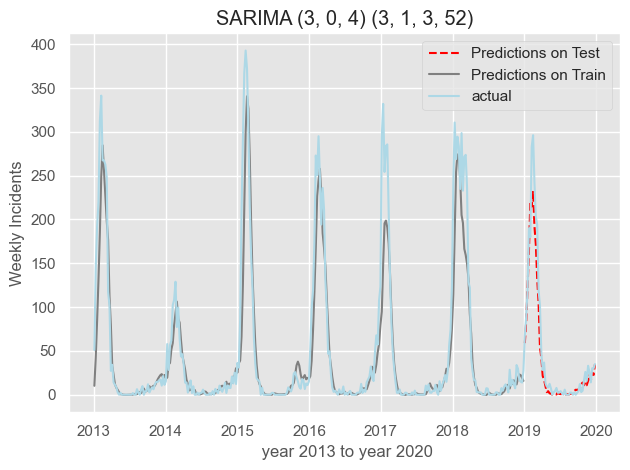

In [118]:
model_sarima = SARIMAX(y_train["georegion_region_5"]["log"],
                                        order=(3, 0, 4),
                                        seasonal_order=(3, 1, 3, 52)).fit(disp=False)


pred_sarima = model_sarima.predict(start=len(y_train), end=len(y_train) + len(y_test)-1, dynamic=False)
pred_sarima = np.exp(pred_sarima) - 1
pred_data_sarima = pd.DataFrame({'pred': pred_sarima})
pred_data_sarima.index = y_test.index

rmse_value = mean_squared_error(y_test["georegion_region_5"]["incValue"], pred_data_sarima, squared=False)
print(rmse_value)

pred_sarima = model_sarima.predict(start=0, end=len(y_train)-1, dynamic=False)
pred_sarima = np.exp(pred_sarima) - 1
pred_data_sarima_train = pd.DataFrame({'pred': pred_arima})
pred_data_sarima_train.index = y_train.index

plt.title(f"SARIMA (3, 0, 4) (3, 1, 3, 52)")
plt.ylabel("Weekly Incidents")
plt.xlabel(" year 2013 to year 2020")
plt.plot(pred_data_sarima, color="red", label="Predictions on Test", linestyle='--')
plt.plot(pred_data_sarima_train, color="grey", label="Predictions on Train")
plt.plot(y["georegion_region_5"]["incValue"], color="lightblue", label="actual")
plt.legend()
plt.tight_layout()
plt.show()

In [119]:
prediction_SARIMA_5 = pd.concat([pred_data_sarima, pred_data_sarima_train], axis = 0)
prediction_SARIMA_5.index = y.index
file_path = 'prediction_SARIMA_5.csv'
prediction_SARIMA_5.to_csv(file_path, index=True)

## SARIMAX (with exogenous variables)

### LASSO Feature selection

Best Alpha for Region 5: {0.99}


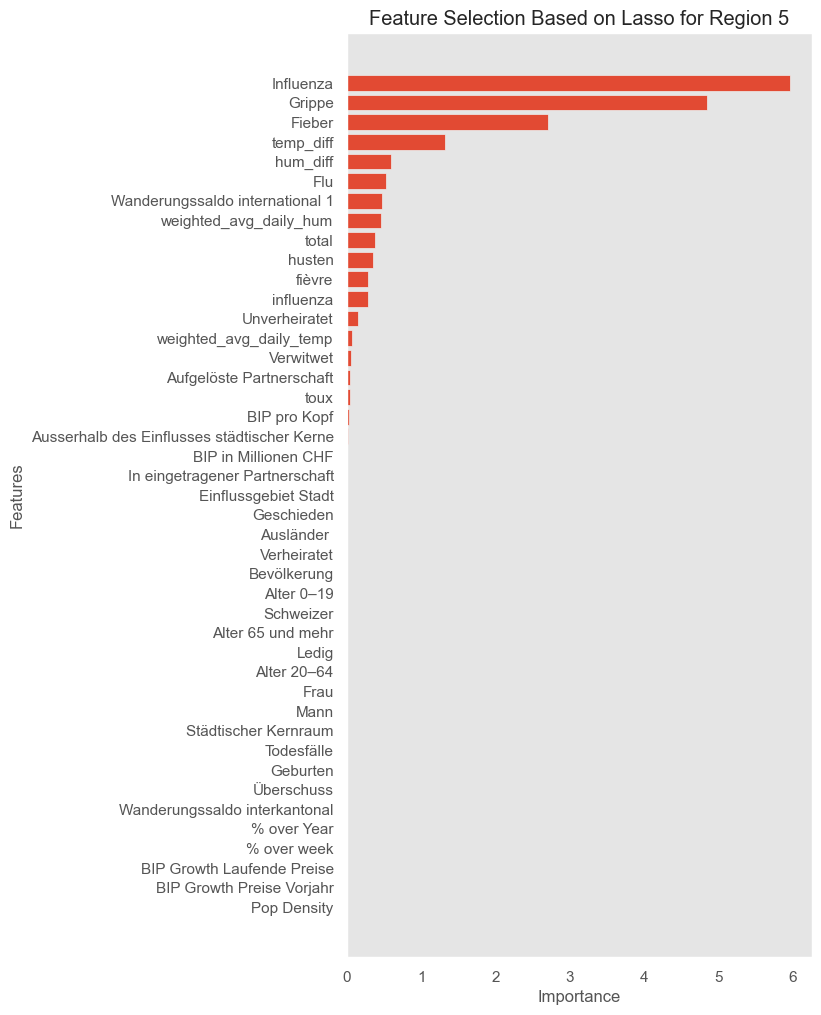

Top 10 Features in Region 5:
Influenza: 5.963820439063615
Grippe: 4.8502613939349155
Fieber: 2.7023893126923864
temp_diff: 1.3244381571343582
hum_diff: 0.5895392375459417
Flu: 0.5312242346664169
Wanderungssaldo international 1: 0.4733713249836989
weighted_avg_daily_hum: 0.465729575791685
total: 0.38502036133190926
husten: 0.35595097095690625


In [129]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a list to store the best alphas for each region
best_alphas = []

# Create a dictionary to store feature importance for each feature
feature_importance = {}

# Standardise the dataset
pipeline = Pipeline([("scaler", StandardScaler()),
                    ("lasso", LassoCV(alphas=np.arange(0.01, 1, 0.01), cv=5))])

pipeline.fit(X["georegion_region_5"], y["georegion_region_5"]["incValue"])

# Get the best alpha for this region
best_alpha = pipeline.named_steps['lasso'].alpha_
best_alphas.append(best_alpha)

print(f"Best Alpha for Region 5:", {best_alpha})

# Create a Lasso model with the best alpha
lasso1 = Lasso(alpha=best_alpha)
lasso1.fit(X["georegion_region_5"], y["georegion_region_5"]["incValue"])

# Make coefficients positive.
lasso1_coef = np.abs(lasso1.coef_)

for feature, coef in zip(X["georegion_region_5"].columns, lasso1_coef):
    if feature in feature_importance:
        feature_importance[feature].append(coef)
    else:
        feature_importance[feature] = [coef]

# Sort coefficients in descending order of importance
sorted_indices = np.argsort(lasso1_coef)[::-1]
sorted_lasso1_coef = lasso1_coef[sorted_indices]
sorted_names = X["georegion_region_5"].columns[sorted_indices]

# Importance Plot
plt.figure(figsize=(6, 12))
plt.barh(sorted_names, sorted_lasso1_coef) 
plt.grid()
plt.title(f"Feature Selection Based on Lasso for Region 5")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

average_importance = {feature: np.mean(coefs) for feature, coefs in feature_importance.items()}

# Sort features by average importance and select the top 5
top_features = sorted(average_importance.keys(), key=lambda x: average_importance[x], reverse=True)[:10]

print("Top 10 Features in Region 5:")
for feature in top_features:
    print(f"{feature}: {average_importance[feature]}")

# We will use all top 2 for now for a lighter computation
# Best Alpha of LASSO seems to converge to positive infinity, which implies multicolinearity in the dataset.
# However, we only use LASSO to select the features so no further operations such as ridge will be performed.

In [138]:
# Data preparation for SARIMAX
nonselected = ["incValue", "log", 'weighted_avg_daily_temp', 
                'influenza', 'fièvre', 'toux',
                'Geburten', 'Todesfälle', 'Überschuss', 
                'Wanderungssaldo interkantonal', '% over Year', 'Alter 0–19', 'Alter 20–64',
                'Alter 65 und mehr', 'Mann', 'Frau', 'Schweizer', 'Ausländer ', 'Ledig',
                'Verheiratet', 'Verwitwet', 'Geschieden', 'Unverheiratet',
                'In eingetragener Partnerschaft', 'Aufgelöste Partnerschaft',
                'Städtischer Kernraum', 'Einflussgebiet Stadt',
                'Ausserhalb des Einflusses städtischer Kerne', 'BIP in Millionen CHF',
                'BIP Growth Laufende Preise', 'BIP Growth Preise Vorjahr',
                'BIP pro Kopf', 'Bevölkerung', '% over week', 'Pop Density']

# A new set of features is selected
X_sarima = georegion_df.drop(nonselected, axis = 1, level = 1)

# Data are shifted by 52 meaning in 2014 we will use the features from 2013 to predict the flucases in 2014
X_sarima_lag = X_sarima.shift(52)
X_sarima_lag = X_sarima_lag.dropna()
X_sarimax_lag_train = X_sarima_lag[X_sarima_lag.index <= "2019-01-01"]
X_sarimax_lag_test = X_sarima_lag[X_sarima_lag.index >= "2019-01-01"]

y_sarimax_train = [y_train.index >= "2014-01-01"]

RMSE on Test Set: 15.767792226919552


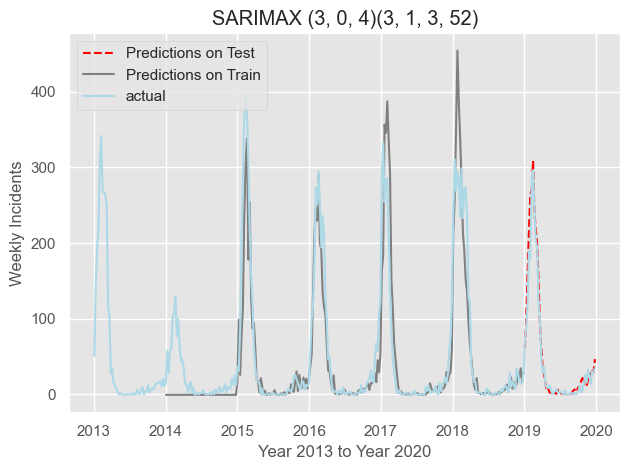

In [148]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(y_sarimax_train["georegion_region_5"]["log"], 
                       exog=X_sarimax_lag_train["georegion_region_5"],
                       order=(3, 0, 4),
                       seasonal_order=(3, 1, 3, 52)).fit(disp=False)

pred_sarima_test = model_sarima.predict(start=len(y_sarimax_train), 
                                        end=len(y_sarimax_train) + len(y_test) - 1, 
                                        exog=X_sarimax_lag_test["georegion_region_5"], 
                                        dynamic=False)
pred_sarima_test = np.exp(pred_sarima_test) - 1
pred_data_sarimax_test = pd.DataFrame({'pred': pred_sarima_test})
pred_data_sarimax_test.index = y_test.index

rmse_value = mean_squared_error(y_test["georegion_region_5"]["incValue"], pred_data_sarimax_test, squared=False)

pred_sarima_train = model_sarima.predict(start=0, 
                                         end=len(y_sarimax_train) - 1, 
                                         exog=X_sarimax_lag_train["georegion_region_5"], 
                                         dynamic=False)
pred_sarima_train = np.exp(pred_sarima_train) - 1
pred_data_sarimax_train = pd.DataFrame({'pred': pred_sarima_train})
pred_data_sarimax_train.index = y_sarimax_train.index

print("RMSE on Test Set:", rmse_value)

# Plotting
plt.title("SARIMAX (3, 0, 4)(3, 1, 3, 52)")
plt.ylabel("Weekly Incidents")
plt.xlabel("Year 2013 to Year 2020")

plt.plot(pred_data_sarimax_test, color="red", label="Predictions on Test", linestyle='--')
plt.plot(pred_data_sarimax_train, color="grey", label="Predictions on Train")
plt.plot(y["georegion_region_5"]["incValue"], color="lightblue", label="actual")
plt.legend()
plt.tight_layout()
plt.show()


In [147]:
prediction_SARIMAX_5 = pd.concat([pred_data_sarimax_train, pred_data_sarimax_test], axis = 0)
prediction_SARIMAX_5.index = y[y.index >= "2014-01-01"].index
file_path = 'prediction_SARIMAX_5.csv'
prediction_SARIMA_5.to_csv(file_path, index=True)

## Grid Search on SARIMA

In [55]:
aic_values = {}
RMSE = {}

d = 0
D = 1
S = 52

dates = ["2014-12-31", "2015-12-31", "2016-12-31", "2017-12-31", "2018-12-31", "2019-12-31"]

for p in range(2, 5):
    for q in range(4, 7):
        for P in range(2, 4):
            for Q in range(2, 4):

                temp_aic_values = []
                temp_rmse_values = []

                for t in range(0, 5):

                    current_train = georegion_df[georegion_df["georegion_region_5"].index <= dates[t]]
                    current_test = georegion_df[(georegion_df["georegion_region_5"].index > dates[t]) & (georegion_df["georegion_region_5"].index <= dates[t + 1])]

                    model_sarima = SARIMAX(y_train["georegion_region_5"]["log"],
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, S)).fit(disp= False)
                    temp_aic_values.append(model_sarima.aic)

                    pred = model_sarima.predict(start=len(current_train), end=len(current_train) + len(current_test) - 1, dynamic=False)
                    pred = np.exp(pred) - 1
                    pred_data = pd.DataFrame({'pred': pred})
                    pred_data.index = current_test.index
                    rmse_value = mean_squared_error(current_test["georegion_region_5"]["incValue"], pred_data, squared=False)
                    temp_rmse_values.append(rmse_value)

                average_aic = np.mean(temp_aic_values)
                average_rmse = np.mean(temp_rmse_values)

                aic_values[(p, d, q, P, D, Q, S)] = average_aic
                RMSE[(p, d, q, P, D, Q, S)] = average_rmse

                print(f"SARIMA({p}, {d}, {q}, {P}, {D}, {Q}, {S}) with regional AIC: {aic_values[(p, d, q, P, D, Q, S)]}, regional RMSE is {RMSE[(p, d, q, P, D, Q, S)]}")

# Finding the best parameters
best_pdq_aic = min(aic_values, key=aic_values.get)
print("Lowest AIC SARIMA is:", best_pdq_aic, aic_values[best_pdq_aic])

best_pdq_rmse = min(RMSE, key=RMSE.get)
print("Lowest RMSE SARIMA is:", best_pdq_rmse, RMSE[best_pdq_rmse])


SARIMA(2, 0, 4, 2, 1, 2, 52) with regional AIC: 645.376321937663, regional RMSE is 37.49689447250543
SARIMA(2, 0, 4, 2, 1, 3, 52) with regional AIC: 647.473857278305, regional RMSE is 37.244074414374175
SARIMA(2, 0, 4, 3, 1, 2, 52) with regional AIC: 647.3157765060477, regional RMSE is 37.0085176772629
SARIMA(2, 0, 4, 3, 1, 3, 52) with regional AIC: 649.3157122778912, regional RMSE is 36.99834581164987
SARIMA(2, 0, 5, 2, 1, 2, 52) with regional AIC: 645.4106945368808, regional RMSE is 37.917098852710026
SARIMA(2, 0, 5, 2, 1, 3, 52) with regional AIC: 647.4100672444386, regional RMSE is 38.13585399795097
SARIMA(2, 0, 5, 3, 1, 2, 52) with regional AIC: 647.3730585290969, regional RMSE is 37.65607880830993
SARIMA(2, 0, 5, 3, 1, 3, 52) with regional AIC: 649.3739360850175, regional RMSE is 37.70839429630847
SARIMA(2, 0, 6, 2, 1, 2, 52) with regional AIC: 647.1691831916157, regional RMSE is 38.70866560791841
SARIMA(2, 0, 6, 2, 1, 3, 52) with regional AIC: 649.2022695903015, regional RMSE is